In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import seed
%matplotlib inline

import statsmodels.api as sm
from scipy.stats import ttest_ind

In [2]:
combined_df = pd.read_csv('combined_df.csv', index_col=0)

C:\Users\David C. Buehler\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
combined_df.head()

,ab_id,b_count,s_count,b_score,batter_id,batter_side,code,g_id,inning,on1b,...,SC,SI,SL,UN,id,first_name,last_name,p_in_ab,year,runners_on
0,2015000001,0,0,0,444876,1.0,C,201500001,1,0.0,...,0.0,0.0,0.149969,0.0,489119,Wade,Miley,1,2015,0
1,2015000001,0,1,0,444876,1.0,F,201500001,1,0.0,...,0.0,0.0,0.149969,0.0,489119,Wade,Miley,2,2015,0
2,2015000001,0,2,0,444876,1.0,B,201500001,1,0.0,...,0.0,0.0,0.149969,0.0,489119,Wade,Miley,3,2015,0
3,2015000001,1,2,0,444876,1.0,D,201500001,1,0.0,...,0.0,0.0,0.149969,0.0,489119,Wade,Miley,4,2015,0
4,2015000002,0,0,0,450314,1.0,F,201500001,1,1.0,...,0.0,0.0,0.149969,0.0,489119,Wade,Miley,1,2015,1


First we're going to perform a bootstrap test to see how significant the score differential is on a pitch thrown. We'll need to make a new column in the data set first to determine what the score differential is. We'll do (batter score - pitcher score), so the more positive the value, the farther the batter is ahead, and the more negative the value, the more the pitcher is ahead.

In [4]:
combined_df['score_diff'] = combined_df['b_score'] - combined_df['p_score']

Let's see a histogram of the values to see if we're working with a normal distribution of differentials.

In [5]:
range_diff = combined_df.score_diff.min() - combined_df.score_diff.max()
-range_diff

48

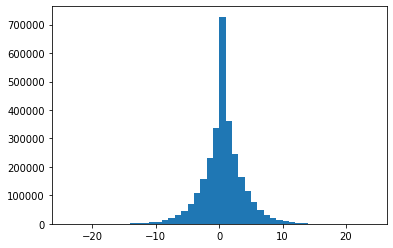

In [6]:
plt.hist(combined_df['score_diff'], bins = -range_diff )
plt.show()

Definitely normally distributed with a large spike at 0, which makes sense since every game starts 0-0

In [7]:
def change_pitch_type(value, target):
    if value == target:
        return 1
    else:
        return 0

In [8]:
def bootstrap_reps(data, func):
    bs_sample = np.random.choice(data, size=len(data))
    return func(bs_sample)

In [9]:
def bootstrap_test(target):
    '''
    This function performs a bootstrap test on a target pitch (FB, BB, OS, OT) to determine the average score
    differential and see if that is statistically significant.
    '''
    
    df = combined_df.copy()
    df['pitch_type'] = df.apply(lambda row:change_pitch_type(row['pitch_type'], target), axis=1)
    
    df_is = df[df.pitch_type == 1]
    df_not = df[df.pitch_type == 0]
    
    np.random.seed(47)
    N_rep = 1000

    is_bs_reps = np.empty(N_rep)
    not_bs_reps = np.empty(N_rep)
    
    for i in range(N_rep):
        is_bs_reps[i] = bootstrap_reps(df_is['score_diff'], np.mean)

    for i in range(N_rep):
        not_bs_reps[i] = bootstrap_reps(df_not['score_diff'], np.mean)

    print(f'95% percentile for pitches that are {target}: {np.percentile(is_bs_reps, [2.5, 97.5])}')
    print(f'95% percentile for pitches that are not {target}: {np.percentile(not_bs_reps, [2.5, 97.5])}')
    
    plt.hist(is_bs_reps, histtype='step', color='b')
    plt.title('Average score differential for pitches that are {}'.format(target))
    plt.xlabel('Average score differential')
    plt.ylabel('Number of occurences')
    plt.axvline(np.percentile(is_bs_reps, 2.5), linewidth=1, color='b', linestyle='--')
    plt.axvline(np.percentile(is_bs_reps, 97.5), linewidth=1, color='b', linestyle='--')
    plt.show()
    
    plt.hist(not_bs_reps, histtype='step', color='r')
    plt.title('Average score differential for pitches that are not {}'.format(target))
    plt.xlabel('Average score differential')
    plt.ylabel('Number of Occurences')
    plt.axvline(np.percentile(not_bs_reps, 2.5), linewidth=1, color='r', linestyle='--')
    plt.axvline(np.percentile(not_bs_reps, 97.5), linewidth=1, color='r', linestyle='--')
    plt.show()
    
    print(ttest_ind(df_not['b_score'], df_is['b_score'], equal_var=False))

The null hypothesis I'm testing is "On average, pitchers will throw the same amount of fastballs/breaking balls/offspeed pitches no matter the score differential" and I'm doing this for a 95% confidence interval, so if the p-value is less than 0.05, I'll reject that hypothesis.

95% percentile for pitches that are FB: [0.01399313 0.02394216]
95% percentile for pitches that are not FB: [0.11105723 0.12194188]


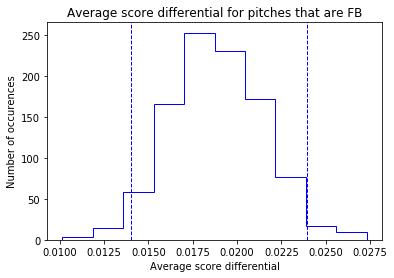

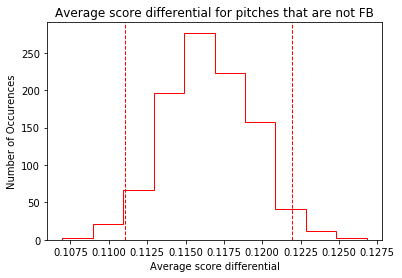

Ttest_indResult(statistic=22.34483040498021, pvalue=1.387219962068423e-110)


In [10]:
bootstrap_test('FB')

95% percentile for pitches that are BB: [0.09700123 0.10988886]
95% percentile for pitches that are not BB: [0.0380822  0.04701646]


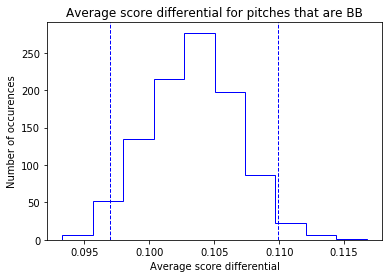

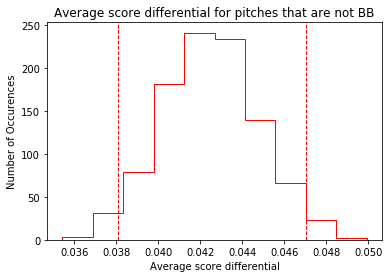

Ttest_indResult(statistic=-35.87238584646978, pvalue=1.042501541694794e-281)


In [11]:
bootstrap_test('BB')

95% percentile for pitches that are OS: [0.11719656 0.13730347]
95% percentile for pitches that are not OS: [0.04871658 0.05659853]


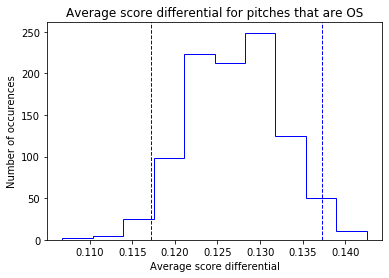

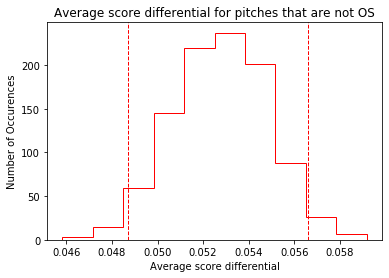

Ttest_indResult(statistic=23.48832734018809, pvalue=6.344112357753109e-122)


In [12]:
bootstrap_test('OS')

After running a p-test for all of the different kinds of pitches tested, they all came back with a p-value of less than 0.05, which means that it's unlikely we saw these results just by chance, and the observed differences are statistically significant.

I didn't test the "other" category though, and wanted to make a special note of it since those heavily depend on the situation of the game, who's at bat, the score of the game, and what team is winning, so let's take a look at that category.

95% percentile for pitches that are OT: [1.11089469 1.20494092]
95% percentile for pitches that are not OT: [0.05519695 0.06253676]


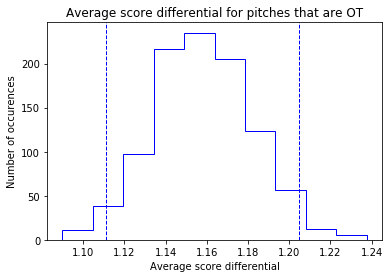

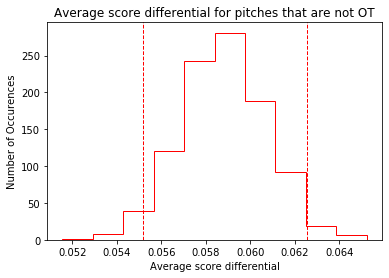

Ttest_indResult(statistic=-40.86550265773747, pvalue=0.0)


In [13]:
bootstrap_test('OT')

A p-value of 0, just as I thought. It's interesting to see the histogram for the score differential with pitches that are in the "other" category. Pitch-outs, which usually lead to intentional walks, are in this category, so seeing the average score differential hover around 1 makes sense, as teams like to walk hitters that they know can cause trouble in close games. Especially if they're power hitters and can tie the game or put the hitting team ahead with one swing of the bat. 

Some of the things we looked at in the Storytelling notebook came up with some interesting results, namely how some of the different variables effected how many fastballs/breaking balls/offspeed were thrown. Two big ones were ball count and strike count, so let's look at how those effected fastball usage.

In [14]:
df_FB = combined_df.copy()
df_FB['pitch_type'] = df_FB.apply(lambda row:change_pitch_type(row['pitch_type'], 'FB'), axis=1)
df_FB['pitch_type']

logit_FB = sm.Logit(df_FB['pitch_type'], df_FB[['b_count', 's_count']]).fit()
logit_FB.summary()

Optimization terminated successfully.
         Current function value: 0.682123
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             pitch_type   No. Observations:              2855212
Model:                          Logit   Df Residuals:                  2855210
Method:                           MLE   Df Model:                            1
Date:                Fri, 06 Dec 2019   Pseudo R-squ.:                0.005822
Time:                        11:24:00   Log-Likelihood:            -1.9476e+06
converged:                       True   LL-Null:                   -1.9590e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
b_count        0.3162      0.001    245.380      0.000       0.314       0.319
s_count       -0.2123      0.001   -155.233      0.000      -0.215      -0.210
==============================================================================
"""

From this quick model, it seems that more fastballs will be thrown as the number of balls in the counts goes up, and less fastballs thrown with more strikes in the count. What about breaking balls?

In [15]:
df_BB = combined_df.copy()
df_BB['pitch_type'] = df_BB.apply(lambda row:change_pitch_type(row['pitch_type'], 'BB'), axis=1)
df_BB['pitch_type']

logit_BB = sm.Logit(df_BB['pitch_type'], df_BB[['b_count', 's_count']]).fit()
logit_BB.summary()

Optimization terminated successfully.
         Current function value: 0.647539
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             pitch_type   No. Observations:              2855212
Model:                          Logit   Df Residuals:                  2855210
Method:                           MLE   Df Model:                            1
Date:                Fri, 06 Dec 2019   Pseudo R-squ.:                -0.03812
Time:                        11:25:03   Log-Likelihood:            -1.8489e+06
converged:                       True   LL-Null:                   -1.7810e+06
Covariance Type:            nonrobust   LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
b_count       -0.4860      0.001   -347.051      0.000      -0.489      -0.483
s_count       -0.0220      0.001    -15.742      0.000      -0.025      -0.019
==============================================================================
"""

Seems like breaking balls would be predicted to go down as pitchers get deeper into the count. This could make sense, we saw in the storytelling portion that pitchers threw more balls than strikes, so this could be a repurcussion of that. Both p-scores are 0 though, which means these are statistically good predicters for this pitch type.

In [16]:
df_OS = combined_df.copy()
df_OS['pitch_type'] = df_OS.apply(lambda row:change_pitch_type(row['pitch_type'], 'OS'), axis=1)
df_OS['pitch_type']

logit_OS = sm.Logit(df_OS['pitch_type'], df_OS[['b_count', 's_count']]).fit()
logit_OS.summary()

Optimization terminated successfully.
         Current function value: 0.504012
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             pitch_type   No. Observations:              2855212
Model:                          Logit   Df Residuals:                  2855210
Method:                           MLE   Df Model:                            1
Date:                Fri, 06 Dec 2019   Pseudo R-squ.:                 -0.3578
Time:                        11:26:59   Log-Likelihood:            -1.4391e+06
converged:                       True   LL-Null:                   -1.0599e+06
Covariance Type:            nonrobust   LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
b_count       -0.6355      0.002   -352.325      0.000      -0.639      -0.632
s_count       -0.7943      0.002   -436.972      0.000      -0.798      -0.791
==============================================================================
"""

Same deal as the breaking balls, as pitchers get deeper in to counts, they seem less likely to throw offspeed pitches, possibly for the same reason as breaking balls.

What about some other factors? Before we looked at the number of runners on and how that effects pitches thrown, let's take a look using the statsmodels, starting with fastballs again.

In [17]:
df_FB = combined_df.copy()
df_FB['pitch_type'] = df_FB.apply(lambda row:change_pitch_type(row['pitch_type'], 'FB'), axis=1)
df_FB['pitch_type']

logit_FB = sm.Logit(df_FB['pitch_type'], df_FB['runners_on']).fit()
logit_FB.summary()

Optimization terminated successfully.
         Current function value: 0.691440
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             pitch_type   No. Observations:              2855212
Model:                          Logit   Df Residuals:                  2855211
Method:                           MLE   Df Model:                            0
Date:                Fri, 06 Dec 2019   Pseudo R-squ.:               -0.007756
Time:                        11:42:22   Log-Likelihood:            -1.9742e+06
converged:                       True   LL-Null:                   -1.9590e+06
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
runners_on     0.1206      0.001     98.378      0.000       0.118       0.123
==============================================================================
"""

Interesting result, seems like as the number of runners on base increases, it seems predicted that a pitcher will be more likely to throw a fastball. That was close to what we saw during the storytelling portion. How about breaking balls?

In [18]:
df_BB = combined_df.copy()
df_BB['pitch_type'] = df_BB.apply(lambda row:change_pitch_type(row['pitch_type'], 'BB'), axis=1)
df_BB['pitch_type']

logit_BB = sm.Logit(df_BB['pitch_type'], df_BB['runners_on']).fit()
logit_BB.summary()

Optimization terminated successfully.
         Current function value: 0.670625
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             pitch_type   No. Observations:              2855212
Model:                          Logit   Df Residuals:                  2855211
Method:                           MLE   Df Model:                            0
Date:                Fri, 06 Dec 2019   Pseudo R-squ.:                -0.07513
Time:                        11:47:18   Log-Likelihood:            -1.9148e+06
converged:                       True   LL-Null:                   -1.7810e+06
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
runners_on    -0.4591      0.001   -341.388      0.000      -0.462      -0.456
==============================================================================
"""

Starting to deviate from what we saw in the storytelling portion. As more runners got on base, it seemed like pitchers threw a higher percentage of breaking balls, but here it's the other way around. As more runners get on base, pitchers will be less likely to throw them, according to the model.

In [19]:
df_OS = combined_df.copy()
df_OS['pitch_type'] = df_OS.apply(lambda row:change_pitch_type(row['pitch_type'], 'OS'), axis=1)
df_OS['pitch_type']

logit_OS = sm.Logit(df_OS['pitch_type'], df_OS['runners_on']).fit()
logit_OS.summary()

Optimization terminated successfully.
         Current function value: 0.567874
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             pitch_type   No. Observations:              2855212
Model:                          Logit   Df Residuals:                  2855211
Method:                           MLE   Df Model:                            0
Date:                Fri, 06 Dec 2019   Pseudo R-squ.:                 -0.5298
Time:                        11:52:28   Log-Likelihood:            -1.6214e+06
converged:                       True   LL-Null:                   -1.0599e+06
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
runners_on    -1.4131      0.002   -640.441      0.000      -1.417      -1.409
==============================================================================
"""

Same as the breaking balls, just more drastic. According to the model, pitchers are far less likely to throw off speed pitches as more runners get on base.